In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import random
import cv2
import albumentations as A

In [2]:
!pip install ultralytics
from ultralytics import YOLO

### Построение алгоритма NMS (Non-Maximum Suppression)

In [3]:
def non_maximum_suppression(boxes, scores, iou_thresh):
    # Сортировка боксов по уверенности в порядке убывания
    sorted_indices = np.argsort(scores)[::-1]

    # Список индексов боксов, которые будут сохранены
    keep_boxes = []

    while len(sorted_indices) > 0:
        # Выбираем бокс с наивысшей уверенностью
        current_index = sorted_indices[0]
        keep_boxes.append(current_index)

        # Вычисляем IoU текущего бокса со всеми остальными
        current_box = boxes[current_index]
        remaining_boxes = boxes[sorted_indices[1:]]

        x1 = np.maximum(current_box[0], remaining_boxes[:, 0])
        y1 = np.maximum(current_box[1], remaining_boxes[:, 1])
        x2 = np.minimum(current_box[2], remaining_boxes[:, 2])
        y2 = np.minimum(current_box[3], remaining_boxes[:, 3])

        # Ширина и высота пересечения
        width = np.maximum(0, x2 - x1)
        height = np.maximum(0, y2 - y1)
        intersection_area = width * height

        # Площадь текущего бокса и оставшихся боксов
        current_area = (current_box[2] - current_box[0]) * (current_box[3] - current_box[1])
        remaining_areas = (remaining_boxes[:, 2] - remaining_boxes[:, 0]) * (remaining_boxes[:, 3] - remaining_boxes[:, 1])

        iou = intersection_area / (current_area + remaining_areas - intersection_area)

        # Оставляем только боксы с IoU ниже порога
        filtered_indices = np.where(iou <= iou_thresh)[0]
        sorted_indices = sorted_indices[filtered_indices + 1]

    return keep_boxes

In [4]:
def visualize_nms(image, boxes, scores, keep_indices):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Рисуем все боксы
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        confidence = scores[i]
        color = 'green' if i in keep_indices else 'red'
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Добавляем текст с уверенностью
        ax.text(x1, y1 - 5, f'{confidence:.3f}', color=color, fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

In [5]:
# Тестирование
# Белое изображение размером 400x400
image = np.ones((400, 400, 3), dtype=np.uint8) * 255
boxes = np.array([
    [50, 50, 150, 150],
    [60, 60, 160, 160],
    [200, 200, 300, 300],
    [220, 220, 320, 320]
])
scores = np.array([0.9, 0.75, 0.8, 0.6])
iou_threshold = 0.1

keep_indices = non_maximum_suppression(boxes, scores, iou_threshold)

print('Индексы сохраненных боксов:', keep_indices)
print('Сохраненные боксы:\n', boxes[keep_indices])

Индексы сохраненных боксов: [np.int64(0), np.int64(2)]
Сохраненные боксы:
 [[ 50  50 150 150]
 [200 200 300 300]]


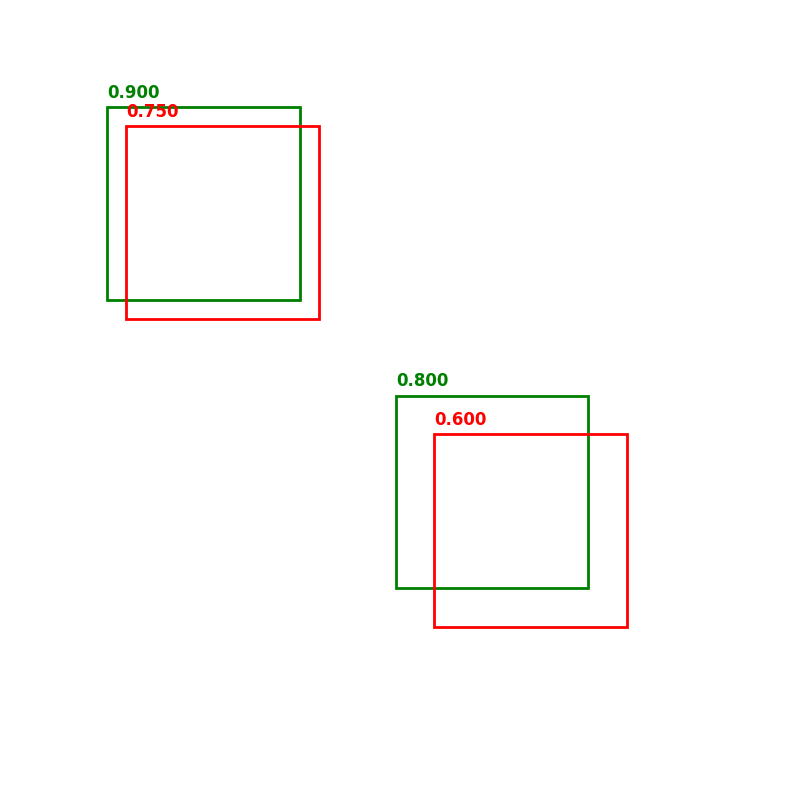

In [6]:
visualize_nms(image, boxes, scores, keep_indices)

In [7]:
iou_threshold = 0.6

keep_indices = non_maximum_suppression(boxes, scores, iou_threshold)

print('Индексы сохраненных боксов:', keep_indices)
print('Сохраненные боксы:\n', boxes[keep_indices])

Индексы сохраненных боксов: [np.int64(0), np.int64(2), np.int64(3)]
Сохраненные боксы:
 [[ 50  50 150 150]
 [200 200 300 300]
 [220 220 320 320]]


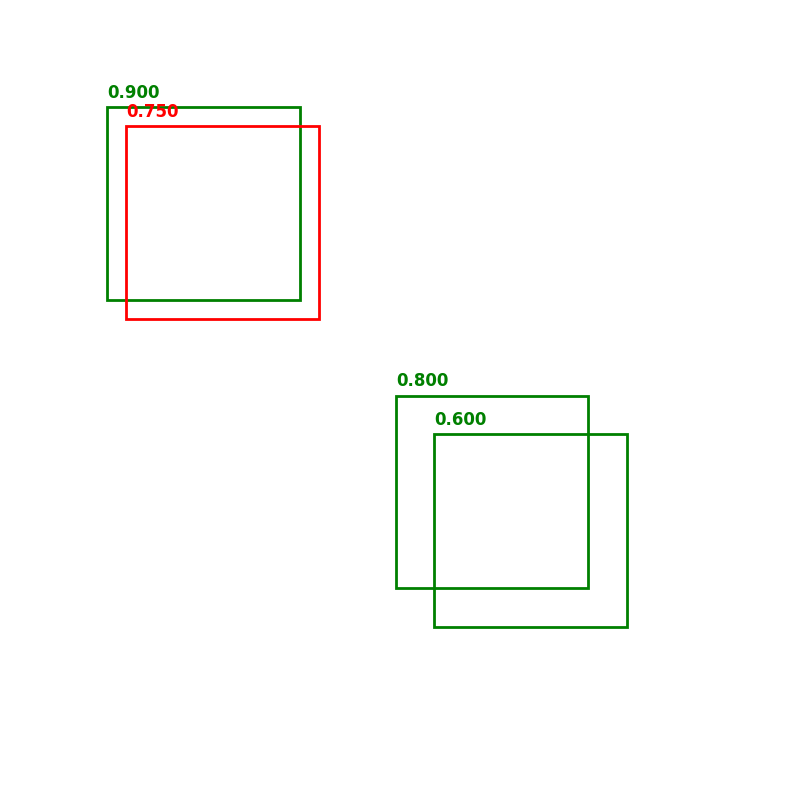

In [8]:
visualize_nms(image, boxes, scores, keep_indices)

### Выводы:
1. При выполнении NMS с порогом перекрытия равным 0.1 , алгоритм сохранил следующие боксы: 0 и 2. Боксы с индексами 1 и 3 были удалены.
Как работает:
* Сортировка боксов по уверенности
Бокс 0: [50, 50, 150, 150] (уверенность = 0.9)
Бокс 2: [200, 200, 300, 300] (уверенность = 0.8)
Бокс 1: [60, 60, 160, 160] (уверенность = 0.75)
Бокс 3: [220, 220, 320, 320] (уверенность = 0.6)
* Выбор бокса с наибольшей уверенностью
Первым выбирается бокс 0 (уверенность = 0.9).
Вычисляется IoU между боксом 0 и остальными боксами:

  Бокс 0 vs Бокс 1 :
  Пересечение: [60, 60, 150, 150]
  Площадь пересечения: (150 - 60) * (150 - 60) = 90 * 90 = 8100
  Площадь объединения: 10000 + 10000 - 8100 = 11900
  IoU: 8100 / 11900 ≈ 0.681

  Бокс 0 vs Бокс 2 :
  Пересечение: [0, 0, 0, 0] (нет пересечения)
  Площадь пересечения: 0
  Площадь объединения: 10000 + 10000 = 20000
  IoU: 0 / 20000 = 0

  Бокс 0 vs Бокс 3 :
  Пересечение: [0, 0, 0, 0] (нет пересечения)
  Площадь пересечения: 0
  Площадь объединения: 10000 + 12000 = 22000
  IoU: 0 / 22000 = 0

  Так как IoU между боксом 0 и боксом 1 составляет 0.681 , который больше порога iou_threshold = 0.1, бокс 1 удаляется.

* Выбор следующего бокса
После удаления бокса 1 осталось:
Бокс 0: [50, 50, 150, 150] (уверенность = 0.9)
Бокс 2: [200, 200, 300, 300] (уверенность = 0.8)
Бокс 3: [220, 220, 320, 320] (уверенность = 0.6)
Выбирается бокс 2 (уверенность = 0.8).
Вычисляется IoU между боксом 2 и оставшимися боксами:

  Бокс 2 vs Бокс 0 :
  Пересечение: [0, 0, 0, 0] (нет пересечения)
  Площадь пересечения: 0
  Площадь объединения: 10000 + 10000 = 20000
  IoU: 0 / 20000 = 0

  Бокс 2 vs Бокс 3 :
  Пересечение: [220, 220, 300, 300]
  Площадь пересечения: (300 - 220) * (300 - 220) = 80 * 80 = 6400
  Площадь объединения: 10000 + 12000 - 6400 = 15600
  IoU: 6400 / 15600 ≈ 0.41

  Так как IoU между боксом 2 и боксом 3 составляет 0.41 , который больше порога iou_threshold = 0.1, бокс 3 удаляется.

2. При использовании низкого порога перекрытия (iou_threshold = 0.1), NMS удаляет боксы, которые имеют хотя бы небольшое пересечение с более уверенными боксами. Однако при пороге iou_threshold = 0.6, боксы с небольшим пересечением (например, бокс 3) остаются, так как их IoU ниже порога. Это демонстрирует гибкость NMS — чем выше порог IoU, тем строже фильтрация избыточных детекций.

### Дообучение модели

Будет использоваться датасет pets_dataset из репозитория https://github.com/ndb796/YOLO-Datasets/tree/main/pets_dataset . Этот набор данных предназначен для задач объектного обнаружения и содержит изображения домашних животных, размеченные в формате YOLO.

Датасет структурирован таким образом, что в папке images находятся изображения, а в папке labels — соответствующие текстовые файлы с аннотациями в формате <class_id> <x_center> <y_center> <width> <height>.

На основе этого датасета планируется дообучить модель YOLOv8n (версия Nano) от Ultralytics, чтобы она могла эффективно детектировать различные породы домашних животных на изображениях. Для этого предполагается использовать предоставленные обучающие (train) и валидационные (val) подвыборки. Целью является улучшение точности распознавания объектов для конкретной предметной области — домашних питомцев.

Также датасет включает YAML-файл конфигурации датасета, который описывает пути к тренировочным и валидационным данным, а также список классов.


In [9]:
# Клонирование репозитория
!git clone https://github.com/ndb796/YOLO-Datasets.git
# Копирование только pets_dataset в текущую директорию
!cp -r YOLO-Datasets/pets_dataset /content/datasets/

fatal: destination path 'YOLO-Datasets' already exists and is not an empty directory.


In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

def show_images_with_boxes(image_dir, label_dir, num_imgs=5):
    # Получаем список всех изображений в директории
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    # Если num_imgs не указан, выбираем случайное количество изображений
    if num_imgs is None:
        num_imgs = random.randint(1, len(image_files))

    # Случайно выбираем указанное количество изображений
    selected_images = random.sample(image_files, num_imgs)

    # Отображаем каждое изображение с bounding box-ами
    for image_name in selected_images:
        image_path = os.path.join(image_dir, image_name)

        base_name = os.path.splitext(image_name)[0]
        label_path = os.path.join(label_dir, f'{base_name}.txt')

        if not os.path.exists(image_path):
            raise FileNotFoundError(f'Изображение {image_path} не найдено.')
        if not os.path.exists(label_path):
            raise FileNotFoundError(f'Файл меток {label_path} не найден.')

        # Загрузка изображения
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f'Не удалось загрузить изображение {image_path}.')

        # Чтение меток из текстового файла
        with open(label_path, 'r') as file:
            lines = file.readlines()

        # Преобразование меток в bounding box-ы
        boxes = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Преобразование нормализованных координат в абсолютные
            img_height, img_width = image.shape[:2]
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # Расчет верхнего левого угла и нижнего правого угла рамки
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            boxes.append((class_id, x1, y1, x2, y2))

        # Визуализация изображения с bounding box-ами
        for class_id, x1, y1, x2, y2 in boxes:
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Отображение изображения
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(base_name)
        plt.axis('off')
        plt.show()

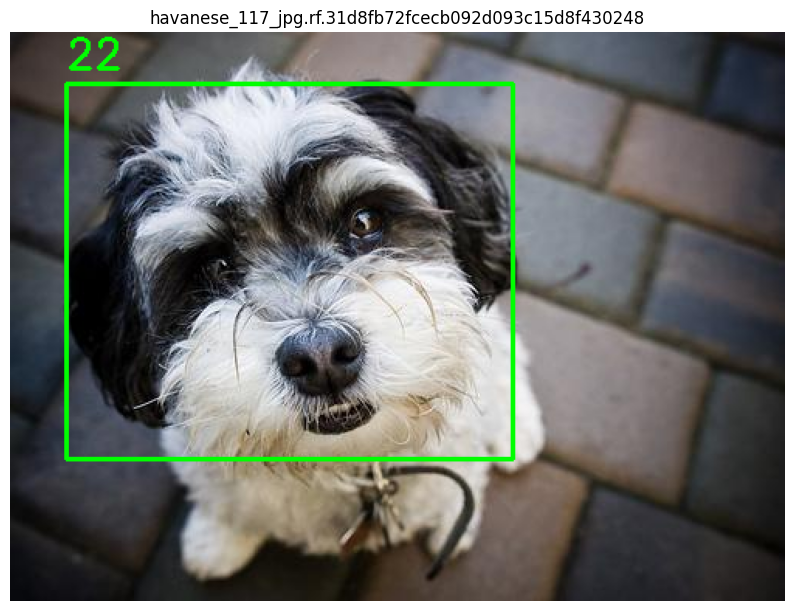

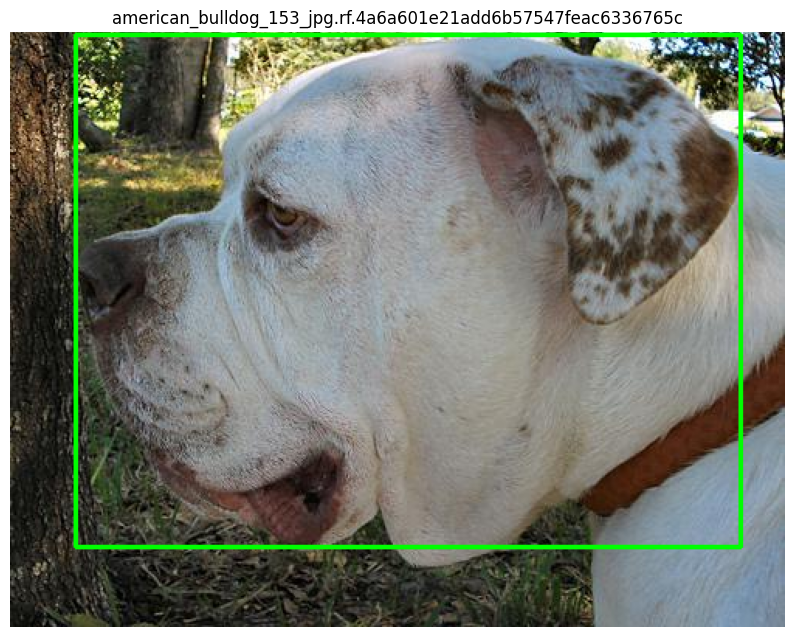

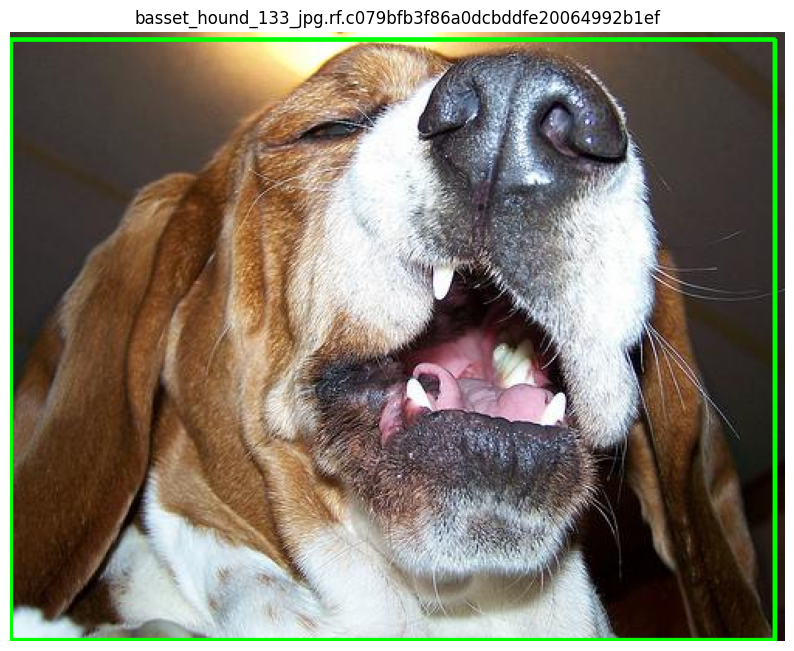

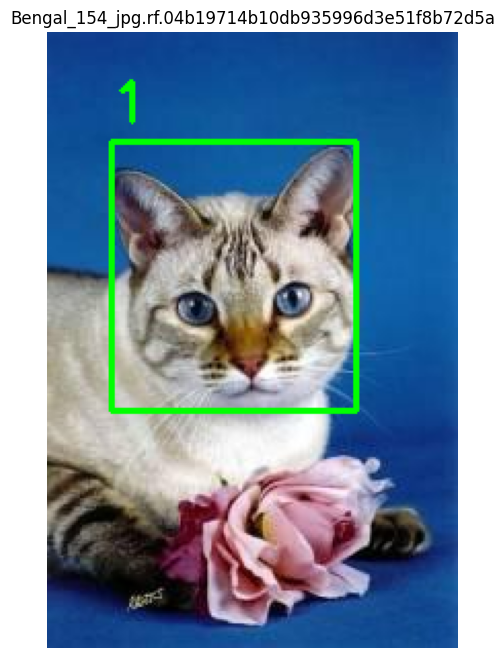

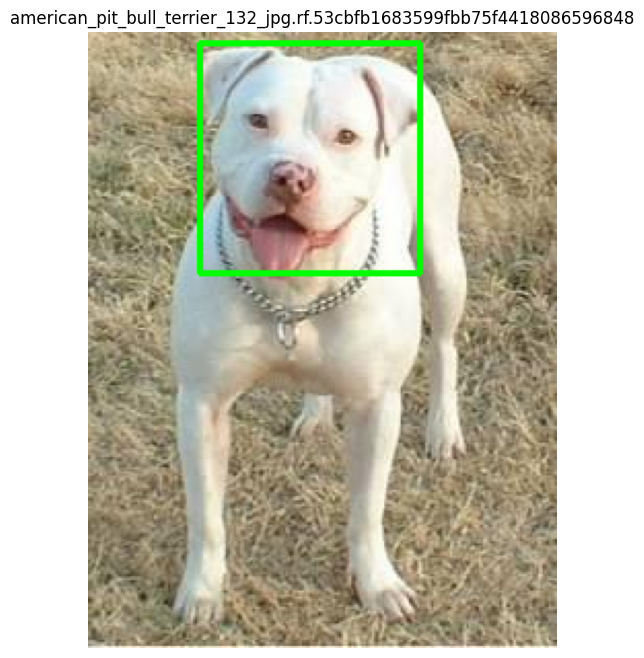

In [11]:
image_dir = 'YOLO-Datasets/pets_dataset/train/images'
label_dir = '/content/datasets/train/labels'

show_images_with_boxes(image_dir, label_dir)

In [12]:
# Загрузка предобученной модели
model = YOLO('yolov8n.pt')

# Настройка параметров обучения
results = model.train(
    data='/content/datasets/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='waste-detection'
)

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=waste-detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

train: Scanning /content/datasets/train/labels... 2508 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2508/2508 [00:02<00:00, 1243.70it/s]


train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 634.2±246.2 MB/s, size: 34.9 KB)


val: Scanning /content/datasets/valid/labels... 716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 716/716 [00:01<00:00, 607.11it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to runs/detect/waste-detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000244, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/waste-detection2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.06G     0.9892      4.551      1.331         26        640: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.41it/s]


                   all        716        718      0.255      0.159     0.0666     0.0507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.89G     0.9302      3.745      1.284         28        640: 100%|██████████| 157/157 [00:46<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]

                   all        716        718      0.203      0.368      0.209      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.9G     0.9076      3.249      1.255         28        640: 100%|██████████| 157/157 [00:45<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]

                   all        716        718      0.318      0.504      0.372      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.92G     0.8991      2.857      1.236         23        640: 100%|██████████| 157/157 [00:44<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]

                   all        716        718      0.442      0.535      0.509      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.94G     0.8631      2.553      1.196         25        640: 100%|██████████| 157/157 [00:43<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]

                   all        716        718      0.463      0.622      0.583      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.96G     0.8423      2.381      1.176         22        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.76it/s]

                   all        716        718      0.554      0.667      0.642      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.97G     0.8228      2.171      1.164         29        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.14it/s]


                   all        716        718      0.542      0.655       0.64      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.99G     0.8026      2.043      1.137         24        640: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.07it/s]

                   all        716        718      0.597      0.648      0.673      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.01G     0.7806      1.916      1.127         25        640: 100%|██████████| 157/157 [00:44<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  3.93it/s]


                   all        716        718      0.616      0.714      0.717      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.02G     0.7672      1.837      1.116         28        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.03it/s]

                   all        716        718      0.667      0.713      0.749      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.04G      0.745      1.729        1.1         25        640: 100%|██████████| 157/157 [00:44<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]


                   all        716        718      0.691      0.706      0.772      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.06G     0.7428      1.629      1.096         18        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.35it/s]

                   all        716        718      0.642      0.755      0.765       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.07G     0.7236      1.572       1.09         19        640: 100%|██████████| 157/157 [00:44<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]

                   all        716        718      0.729      0.726      0.789      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.09G     0.7234      1.482      1.085         26        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.50it/s]

                   all        716        718      0.693      0.724      0.795      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.11G     0.7076      1.431       1.07         34        640: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.40it/s]

                   all        716        718      0.784      0.763      0.849      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.12G      0.713      1.376      1.072         26        640: 100%|██████████| 157/157 [00:43<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]

                   all        716        718      0.754      0.784      0.841      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.14G     0.7045      1.332      1.071         24        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.38it/s]

                   all        716        718      0.757      0.759      0.849      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.16G     0.6869        1.3      1.058         28        640: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]

                   all        716        718      0.752      0.763      0.847      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.18G     0.6788      1.224      1.048         28        640: 100%|██████████| 157/157 [00:44<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.56it/s]

                   all        716        718      0.779      0.795      0.858      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.19G     0.6651      1.184      1.043         28        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.53it/s]

                   all        716        718      0.796        0.8      0.866      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.21G     0.6663      1.172      1.043         22        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.80it/s]

                   all        716        718      0.779      0.801      0.864      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.23G     0.6474      1.112      1.037         24        640: 100%|██████████| 157/157 [00:43<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]

                   all        716        718      0.818       0.78      0.879      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.24G     0.6538      1.083      1.036         30        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.71it/s]

                   all        716        718      0.815      0.816      0.884      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.26G     0.6406      1.069      1.028         29        640: 100%|██████████| 157/157 [00:43<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]

                   all        716        718      0.876      0.794      0.892       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.28G     0.6325      1.041      1.023         23        640: 100%|██████████| 157/157 [00:44<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.71it/s]

                   all        716        718        0.8      0.814      0.883      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.3G     0.6158      1.005      1.017         29        640: 100%|██████████| 157/157 [00:43<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]

                   all        716        718      0.842      0.783      0.886      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.31G     0.6188     0.9694       1.02         24        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.00it/s]

                   all        716        718       0.82      0.802      0.885      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.33G      0.614     0.9547      1.023         25        640: 100%|██████████| 157/157 [00:44<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.48it/s]


                   all        716        718      0.823      0.827       0.89       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.35G     0.6083     0.9271      1.005         23        640: 100%|██████████| 157/157 [00:43<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]

                   all        716        718      0.808      0.851       0.89      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.37G        0.6      0.914          1         31        640: 100%|██████████| 157/157 [00:43<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.46it/s]

                   all        716        718      0.817      0.804      0.891       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.38G     0.6026     0.9128      1.008         28        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.60it/s]

                   all        716        718      0.889      0.791      0.904      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.4G      0.586     0.8616      1.004         32        640: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.48it/s]

                   all        716        718      0.857      0.816      0.905      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.42G     0.5922     0.8596      1.001         38        640: 100%|██████████| 157/157 [00:45<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]

                   all        716        718      0.863      0.832      0.914      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.43G     0.5924     0.8461          1         30        640: 100%|██████████| 157/157 [00:44<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.04it/s]


                   all        716        718      0.864      0.821      0.909      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.45G     0.5648      0.829      0.987         28        640: 100%|██████████| 157/157 [00:45<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.47it/s]

                   all        716        718      0.859      0.804      0.906      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.47G     0.5739     0.8177     0.9877         30        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  3.88it/s]

                   all        716        718      0.831      0.843      0.906      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.48G     0.5669     0.7899     0.9901         27        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        716        718      0.844      0.824       0.91      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.5G      0.578     0.7963     0.9919         30        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.72it/s]


                   all        716        718      0.823      0.824      0.898      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.52G     0.5599     0.7783     0.9869         28        640: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.46it/s]

                   all        716        718      0.865      0.814      0.915      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.54G     0.5698     0.7806     0.9909         27        640: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]

                   all        716        718      0.842      0.874      0.916      0.793


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.55G     0.4534     0.6689     0.9136         12        640: 100%|██████████| 157/157 [00:44<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]

                   all        716        718      0.797      0.862      0.894       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.57G      0.431     0.6019     0.9041         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.50it/s]

                   all        716        718      0.822      0.859      0.905      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.59G     0.4269     0.5817     0.9037         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.48it/s]

                   all        716        718       0.87      0.838      0.908      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.61G     0.4184     0.5692      0.902         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.30it/s]

                   all        716        718      0.895      0.804      0.911      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.62G     0.4115     0.5534      0.887         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]

                   all        716        718      0.867      0.846      0.913      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.64G     0.4047     0.5336     0.8832         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]

                   all        716        718      0.836      0.862      0.915      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.66G     0.4008      0.526     0.8867         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


                   all        716        718      0.879      0.821      0.916        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.67G     0.4043      0.519     0.8832         12        640: 100%|██████████| 157/157 [00:41<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  3.91it/s]

                   all        716        718      0.865       0.84      0.916      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.69G     0.3877     0.5099      0.881         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.55it/s]

                   all        716        718      0.834      0.869      0.917      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.71G     0.3935     0.5161      0.877         12        640: 100%|██████████| 157/157 [00:42<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.49it/s]

                   all        716        718      0.887      0.831      0.919      0.803



50 epochs completed in 0.702 hours.
Optimizer stripped from runs/detect/waste-detection2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/waste-detection2/weights/best.pt, 6.2MB

Validating runs/detect/waste-detection2/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,012,863 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.60it/s]


                   all        716        718      0.887       0.83      0.919      0.803
        cat-Abyssinian         16         16      0.923      0.745      0.903      0.859
            cat-Bengal         23         25      0.747        0.6      0.774      0.702
            cat-Birman         26         26       0.88       0.85      0.913      0.799
            cat-Bombay         22         22      0.906      0.955      0.973       0.82
 cat-British_Shorthair         19         19      0.804      0.947      0.929      0.802
      cat-Egyptian_Mau         17         17       0.69      0.765      0.857      0.807
        cat-Maine_Coon         19         19      0.919      0.895      0.983      0.875
           cat-Persian         18         18      0.927      0.944      0.968      0.839
           cat-Ragdoll         20         20          1      0.745      0.888      0.769
      cat-Russian_Blue         25         25      0.907        0.8      0.934      0.878
           cat-Siames

In [13]:
# Оценка модели
metrics = model.val()
print(metrics)

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,012,863 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 873.9±293.1 MB/s, size: 27.2 KB)


val: Scanning /content/datasets/valid/labels.cache... 716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 716/716 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.15it/s]


                   all        716        718      0.883      0.837      0.917      0.802
        cat-Abyssinian         16         16      0.923       0.75      0.903      0.857
            cat-Bengal         23         25      0.741        0.6      0.775      0.703
            cat-Birman         26         26      0.879      0.842      0.906      0.797
            cat-Bombay         22         22      0.904      0.955      0.973      0.829
 cat-British_Shorthair         19         19      0.805      0.947      0.929      0.803
      cat-Egyptian_Mau         17         17      0.685      0.765      0.857      0.799
        cat-Maine_Coon         19         19      0.912      0.895      0.983      0.875
           cat-Persian         18         18      0.926      0.944      0.968      0.821
           cat-Ragdoll         20         20      0.936       0.75      0.886      0.766
      cat-Russian_Blue         25         25      0.942        0.8      0.946      0.882
           cat-Siames


image 1/356 /content/datasets/test/images/Abyssinian_127_jpg.rf.b2553880d73a78e26e396fe7775f31be.jpg: 640x448 1 cat-Abyssinian, 10.4ms
image 2/356 /content/datasets/test/images/Abyssinian_131_jpg.rf.3aeee0801499f335e3a59b51189e1351.jpg: 640x640 1 cat-Abyssinian, 8.1ms
image 3/356 /content/datasets/test/images/Abyssinian_149_jpg.rf.b6b4a72a93f8bc2b239b18c5d181190c.jpg: 480x640 1 cat-Abyssinian, 7.3ms
image 4/356 /content/datasets/test/images/Abyssinian_155_jpg.rf.fdd90a163673ab77ec9690317a69b94e.jpg: 416x640 1 cat-Abyssinian, 6.9ms
image 5/356 /content/datasets/test/images/Abyssinian_15_jpg.rf.7bc44eeb9865e35cb1d5f9ef4f53b381.jpg: 576x640 1 cat-Abyssinian, 7.8ms
image 6/356 /content/datasets/test/images/Abyssinian_167_jpg.rf.1d367cb1cf82c1e5ebda79fda928cee5.jpg: 640x640 1 cat-Bengal, 7.9ms
image 7/356 /content/datasets/test/images/Abyssinian_174_jpg.rf.e2cf9b76cf12896d0a5672ad19fbd519.jpg: 512x640 1 cat-Abyssinian, 6.7ms
image 8/356 /content/datasets/test/images/Bengal_103_jpg.rf.bb684

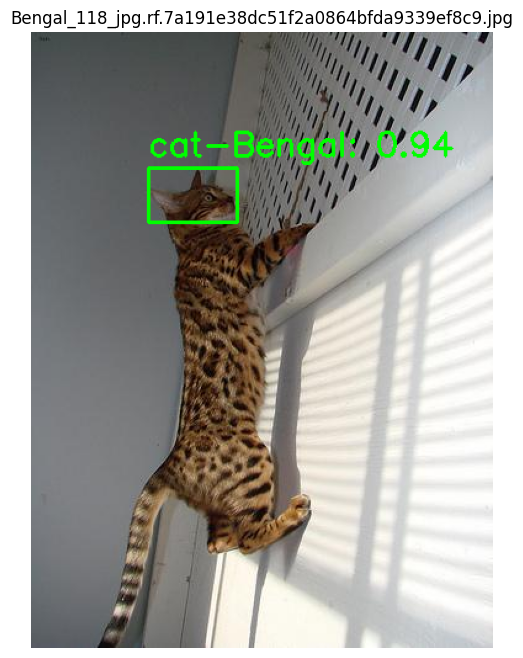

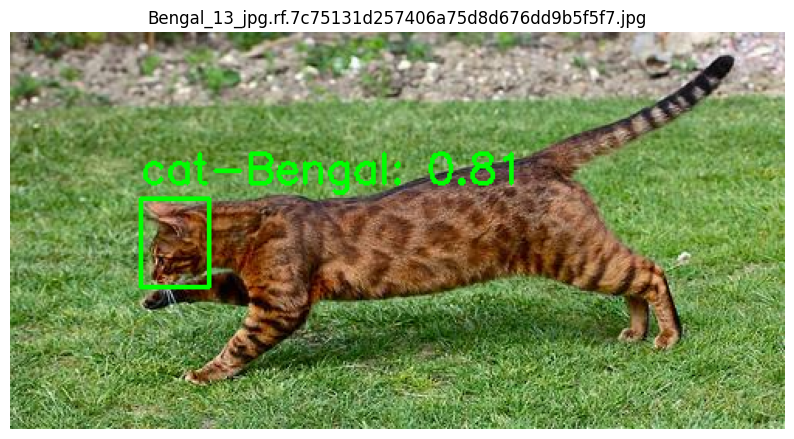

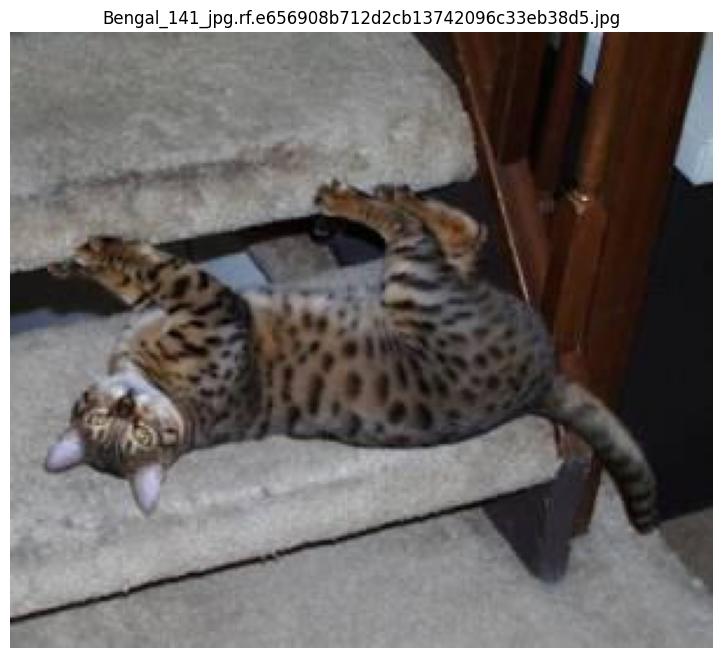

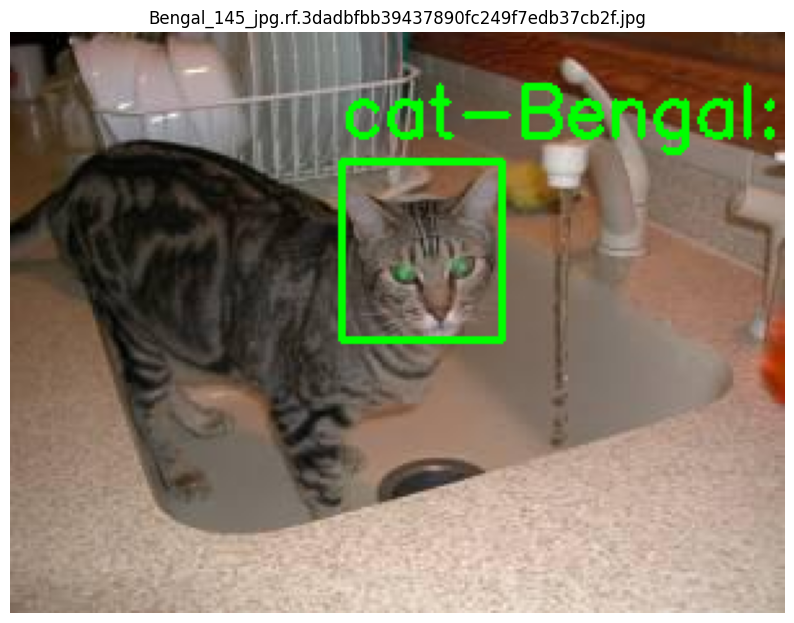

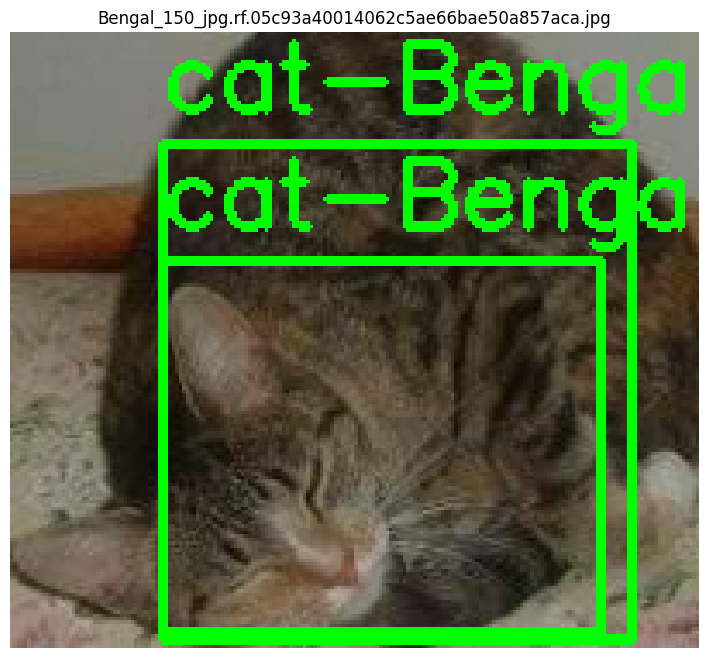

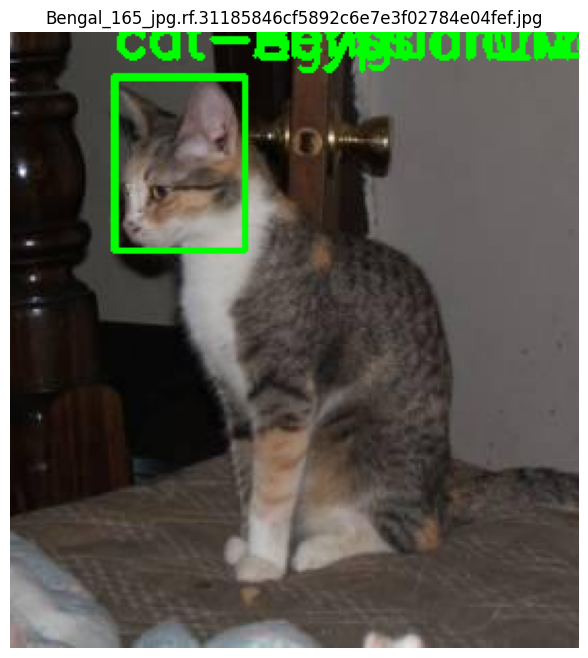

In [16]:
#Тестирование модели
# Путь к директории с тестовыми изображениями
test_image_dir = '/content/datasets/test/images'

# Выполнить предсказание
results = model.predict(source=test_image_dir, save=True)

# Отображения изображений с bounding box-ами
def show_predictions(results):
    for result in results:
        # Получаем информацию о предсказании
        boxes = result.boxes.xyxy.cpu().numpy()  # Координаты bounding box-ов
        labels = result.boxes.cls.cpu().numpy().astype(int)  # Классы объектов
        scores = result.boxes.conf.cpu().numpy()  # Scores

        # Загружаем исходное изображение
        image_path = result.path
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f'Не удалось загрузить изображение {image_path}.')

        # Преобразуем цветовое пространство BGR -> RGB для matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Отображаем bounding box-ы
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = map(int, box)

            # Рисуем рамку
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Добавляем метку класса и score
            label_text = f"{result.names[int(label)]}: {score:.2f}"
            cv2.putText(image_rgb, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Отображаем изображение
        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()

# Отображаем результаты предсказания
show_predictions(results[10:16])

### Выводы:

* Box Precision (P): 0.883. Модель демонстрирует высокую точность предсказаний, что указывает на малое количество ложноположительных срабатываний.
* Box Recall (R): 0.837. Высокий показатель полноты говорит о том, что модель хорошо находит большинство объектов в изображениях.
* mAP50: 0.917. Средняя точность при пороге IoU 0.7 составляет 91.7%, что является отличным результатом.
* mAP50-95: 0.802. Усредненная метрика mAP50-95 (учитывающая более строгие пороги совпадения IoU от 0.5 до 0.95) также показывает высокую производительность.
* Модель демонстрирует высокую общую производительность как по точности, так и по полноте, что делает её надежной для задачи детекции объектов.

* Лучшие классы:
  - cat-Sphynx (mAP50 = 0.995, mAP50-95 = 0.977)
  - dog-keeshond (mAP50 = 0.995, mAP50-95 = 0.885)
  - dog-saint_bernard (mAP50 = 0.99, mAP50-95 = 0.927)
  - dog-pomeranian (mAP50 = 0.995, mAP50-95 = 0.783)

  Эти классы имеют почти идеальную точность и полноту, что может быть связано с качеством данных (например, четкими изображениями или большим количеством примеров).
* Худшие классы:
  - cat-Bengal (mAP50 = 0.775, mAP50-95 = 0.703)
  - dog-boxer (mAP50 = 0.725, mAP50-95 = 0.616)
  - dog-english_setter (mAP50 = 0.85, mAP50-95 = 0.707)
  
  Эти классы показывают худшие результаты, что может быть вызвано недостаточным количеством данных, сложностью распознавания (например, схожестью с другими классами) или несбалансированностью данных.

### Аугментация изображений

In [20]:
# Визуализация аугментированных изображений с оригиналом
def show_aug_img(img, aug_img):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Оригинал')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Аугментированное')
    plt.imshow(aug_img)
    plt.axis('off')
    plt.show()

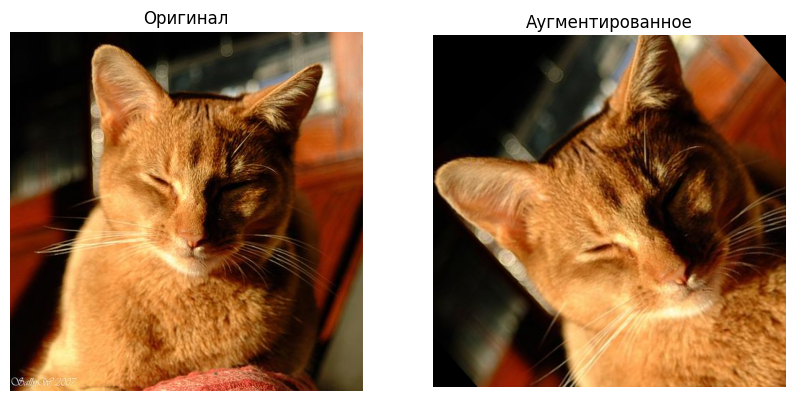

In [21]:
# Загрузка изображения
image = np.array(Image.open('/content/datasets/train/images/Abyssinian_112_jpg.rf.57670a8ed2eb71e777c578326870e7c9.jpg'))

# Примеры аугментаций
transform = A.Compose([
    A.Rotate(limit=45, p=1),  # Поворот
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Изменение яркости и контраста
    A.Crop(x_min=0, y_min=0, x_max=400, y_max=400, p=1),  # Обрезка
])

# Применение аугментаций
augmented = transform(image=image)
augmented_image = augmented['image']

show_aug_img(image, augmented_image)

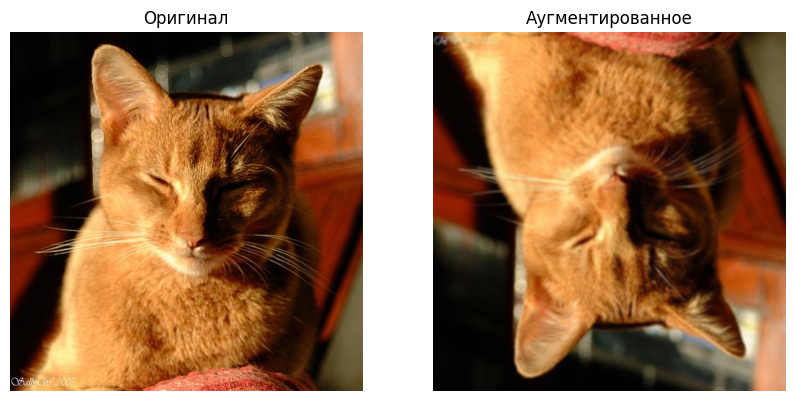

In [25]:
# Примеры аугментаций
transform = A.Compose([
    A.VerticalFlip(p=0.5),  # Вертикальное отражение
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # Размытие по Гауссу
    A.RGBShift(r_shift_limit=40, g_shift_limit=10, b_shift_limit=20, p=0.5),  # Сдвиг каналов RGB
])

# Применение аугментаций
augmented = transform(image=image)
augmented_image = augmented['image']

show_aug_img(image, augmented_image)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


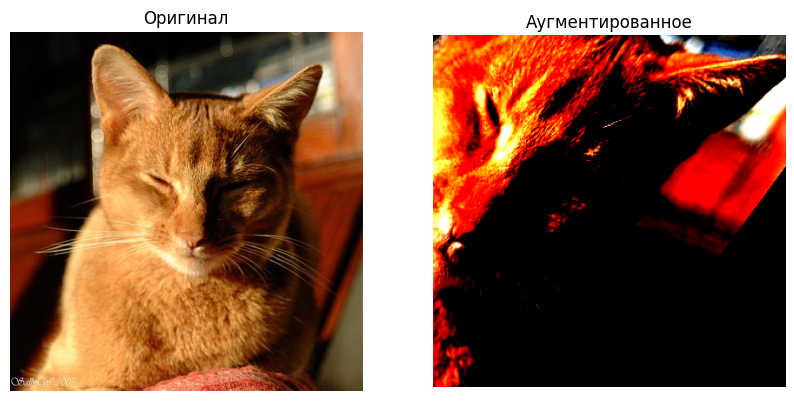

In [23]:
# Примеры аугментаций
transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Изменение цветового тона, насыщенности и яркости
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),  # Сдвиг, масштабирование и поворот
    A.RandomCrop(width=300, height=300, p=1),  # Случайная обрезка
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1),  # Нормализация
])

# Применение аугментаций
augmented = transform(image=image)
augmented_image = augmented['image']

show_aug_img(image, augmented_image)

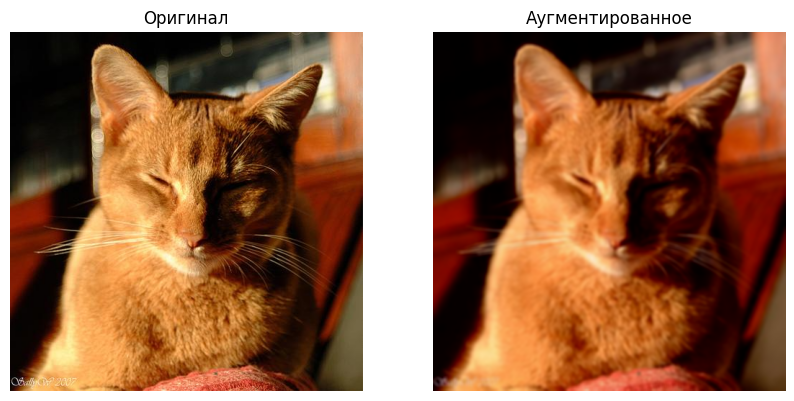

In [24]:
# Примеры аугментаций
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Горизонтальное отражение
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # Размытие по Гауссу
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),  # Сдвиг каналов RGB
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),  # Сдвиг, масштабирование и поворот
])

# Применение аугментаций
augmented = transform(image=image)
augmented_image = augmented['image']

show_aug_img(image, augmented_image)